# Loading, Cleaning, and Preprocessing DTI Datasets

Davis and KIBA datasets, see: https://tdcommons.ai/multi_pred_tasks/dti#davis

Datasets are downloaded from the official [`tdc`](https://pypi.org/project/PyTDC/) package. Random and cold splits are generated through their built-in functions. Additionally, a few filters are applied to remove non-drug-like molecules and targets larger than 1024 amino acids. Lastly, the y interaction value is transformed according to standard practice in the field.

Several visualization of the resulting datasets are provided to give a sense of the data distribution.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from tdc.multi_pred import DTI
from typing import Literal
from sklearn.model_selection import train_test_split

np.random.seed(42)

# Filters (partially adapted from https://github.com/PatWalters/rd_filters)
filter_num_heavy_atoms = 60
filter_molecular_weight = 600
filter_target_seq_length = 1200
# filter_LogP = [-5, 5]

def generate_df(name: Literal['DAVIS', 'KIBA'], use_standardized: bool = True) -> pd.DataFrame:
    """
    Takes as argument the name of the tdc dataset to be processed.
    - Loads the dataset (and converts y predictor variable to log scale if DAVIS dataset)
    - Calculates metrics for drugs and targets
    - Applies filters to the dataset
    - Visualizes the distribution of drug, target and y properties
    - Generates random (7:2:1) and cold (7.5:1.5:1) splits using tdc's built-in get_split method
    """
    # Load the dataset
    data = DTI(name=name)
    if name == 'DAVIS':
        data.convert_to_log(form = 'binding')
    
    split = data.get_split()
    train, valid, test = split['train'], split['valid'], split['test']
    df_rand = pd.concat([train, valid, test], axis=0)
    df_rand['split_rand'] = ["train"] * len(train) + ["valid"] * len(valid) + ["test"] * len(test)

    split = data.get_split('cold_split', column_name='Drug')
    train, valid, test = split['train'], split['valid'], split['test']
    df_cold = pd.concat([train, valid, test], axis=0)
    df_cold['split_cold'] = ["train"] * len(train) + ["valid"] * len(valid) + ["test"] * len(test)

    df = pd.merge(df_rand, df_cold, on=['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y'], how='inner')
    unique_drugs = df.Drug.unique()
    unique_targets = df.Target.unique()

    # Calculate metrics
    unique_MW = {drug: Descriptors.MolWt(Chem.MolFromSmiles(drug)) for drug in unique_drugs}
    unique_LogP = {drug: Descriptors.MolLogP(Chem.MolFromSmiles(drug)) for drug in unique_drugs}
    unique_HeavyAtoms = {drug: Descriptors.HeavyAtomCount(Chem.MolFromSmiles(drug)) for drug in unique_drugs}
    unique_TagetLength = {target: len(target) for target in unique_targets}

    df['MW'] = df['Drug'].map(unique_MW)
    df['LogP'] = df['Drug'].map(unique_LogP)
    df['HeavyAtoms'] = df['Drug'].map(unique_HeavyAtoms)
    df['TargetLength'] = df['Target'].map(unique_TagetLength)
    df['normalized'] = (df['Y'] - df['Y'].mean()) / df['Y'].std()
    df['standardized'] = (df['Y'] - df['Y'].min()) / (df['Y'].max() - df['Y'].min())

    # Apply filters
    df = df[df['HeavyAtoms'] <= filter_num_heavy_atoms]
    df = df[df['MW'] <= filter_molecular_weight]
    # df = df[(df['LogP'] >= filter_LogP[0]) & (df['LogP'] <= filter_LogP[1])]
    df = df[df['TargetLength'] <= filter_target_seq_length]

    # Ensure each unique drug and target appears at least 10 times
    drug_counts = df['Drug'].value_counts()
    valid_drugs = drug_counts[drug_counts >= 10].index
    df = df[df['Drug'].isin(valid_drugs)]

    target_counts = df['Target'].value_counts()
    valid_targets = target_counts[target_counts >= 10].index
    df = df[df['Target'].isin(valid_targets)]

    # Explore properties of drugs and targets
    print("\nDrug & Target properties:", name)
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    sns.histplot(df['MW'], ax=axes[0][0])
    axes[0][0].set_title('Molecular Weight Distribution')
    axes[0][0].set_xlabel('Molecular Weight')
    sns.histplot(df['LogP'], ax=axes[0][1])
    axes[0][1].set_title('LogP Distribution')
    axes[0][1].set_xlabel('LogP')
    sns.histplot(df['HeavyAtoms'], ax=axes[1][0])
    axes[1][0].set_title('Heavy Atom Count Distribution')
    axes[1][0].set_xlabel('Heavy Atom Count')
    sns.histplot(df['TargetLength'], ax=axes[1][1])
    axes[1][1].set_title('Target Sequence Length Distribution')
    axes[1][1].set_xlabel('Target Sequence Length')
    plt.tight_layout()
    plt.show()
    
    # Explore binding affinity
    print("\nBinding affinity:", name)
    y_lim = [0, 100, 8000, 8400] if name == 'DAVIS' else [0, 5000, 11000, 11500]
    # Assuming df is already defined and contains the data
    data_list = ['Y', 'normalized', 'standardized']
    titles = ['Binding Affinity Distribution', 'Normalized Binding Affinity Distribution (min-max)', 'Standardized Binding Affinity Distribution']
    xlabels = ['Binding Affinity', 'Normalized Binding Affinity', 'Standardized Binding Affinity']

    fig, axes = plt.subplots(
        2, 3, figsize=(15, 8), sharex='col', gridspec_kw={'height_ratios': [1, 2]}
    )
    fig.subplots_adjust(hspace=0.1)

    for i, (data_col, title, xlabel) in enumerate(zip(data_list, titles, xlabels)):
        # Plot the data on both upper and lower axes
        sns.histplot(df[data_col], ax=axes[0, i])
        sns.histplot(df[data_col], ax=axes[1, i])
        
        axes[0, i].set_title(title)
        axes[0, i].set_ylabel('')
        axes[1, i].set_xlabel(xlabel)
        
        # Set y-limits for upper and lower plots (adjust as needed)
        axes[0, i].set_ylim(y_lim[2], y_lim[3])
        axes[1, i].set_ylim(y_lim[0], y_lim[1])
        
        # Hide spines between axes
        axes[0, i].spines['bottom'].set_visible(False)
        axes[1, i].spines['top'].set_visible(False)
        axes[0, i].tick_params(labelbottom=False, bottom=False)
        axes[1, i].xaxis.tick_bottom()
        
        # Add slanted lines to indicate broken axes
        d = .015  # Size of diagonal lines in axes coordinates
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                    linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        axes[0, i].plot([0, 1], [0, 0], transform=axes[0, i].transAxes, **kwargs)
        axes[1, i].plot([0, 1], [1, 1], transform=axes[1, i].transAxes, **kwargs)

    plt.tight_layout()
    plt.show()

    if use_standardized:
        df = df[['Drug_ID', 'Drug', 'Target_ID', 'Target', 'standardized', 'split_rand', 'split_cold']]
        df = df.rename(columns={'standardized': 'Y'})
    else:
        df = df[['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y', 'split_rand', 'split_cold']]
    return df


Found local copy...
Loading...
Done!
To log space...



Drug & Target properties: DAVIS


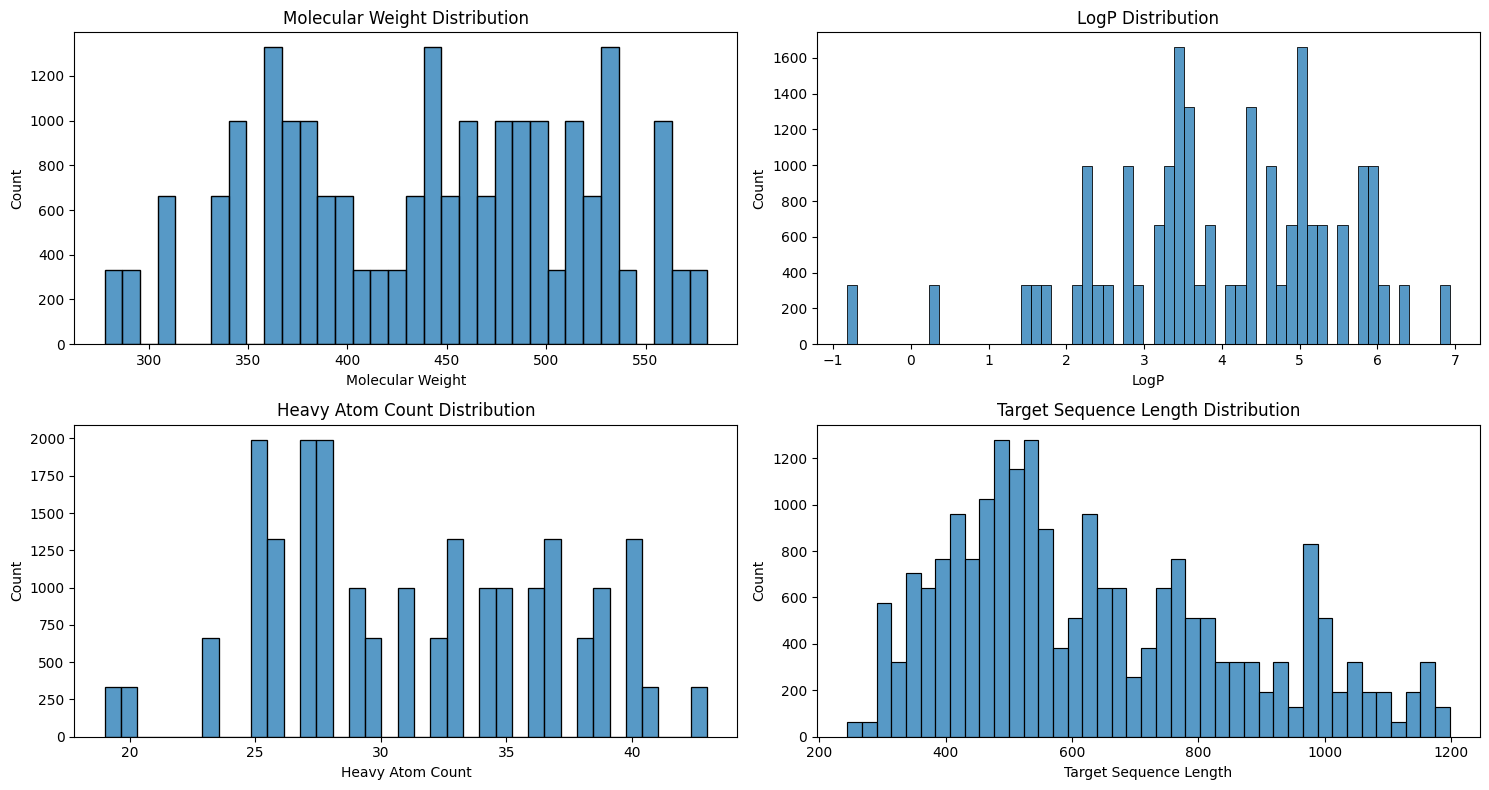


Binding affinity: DAVIS


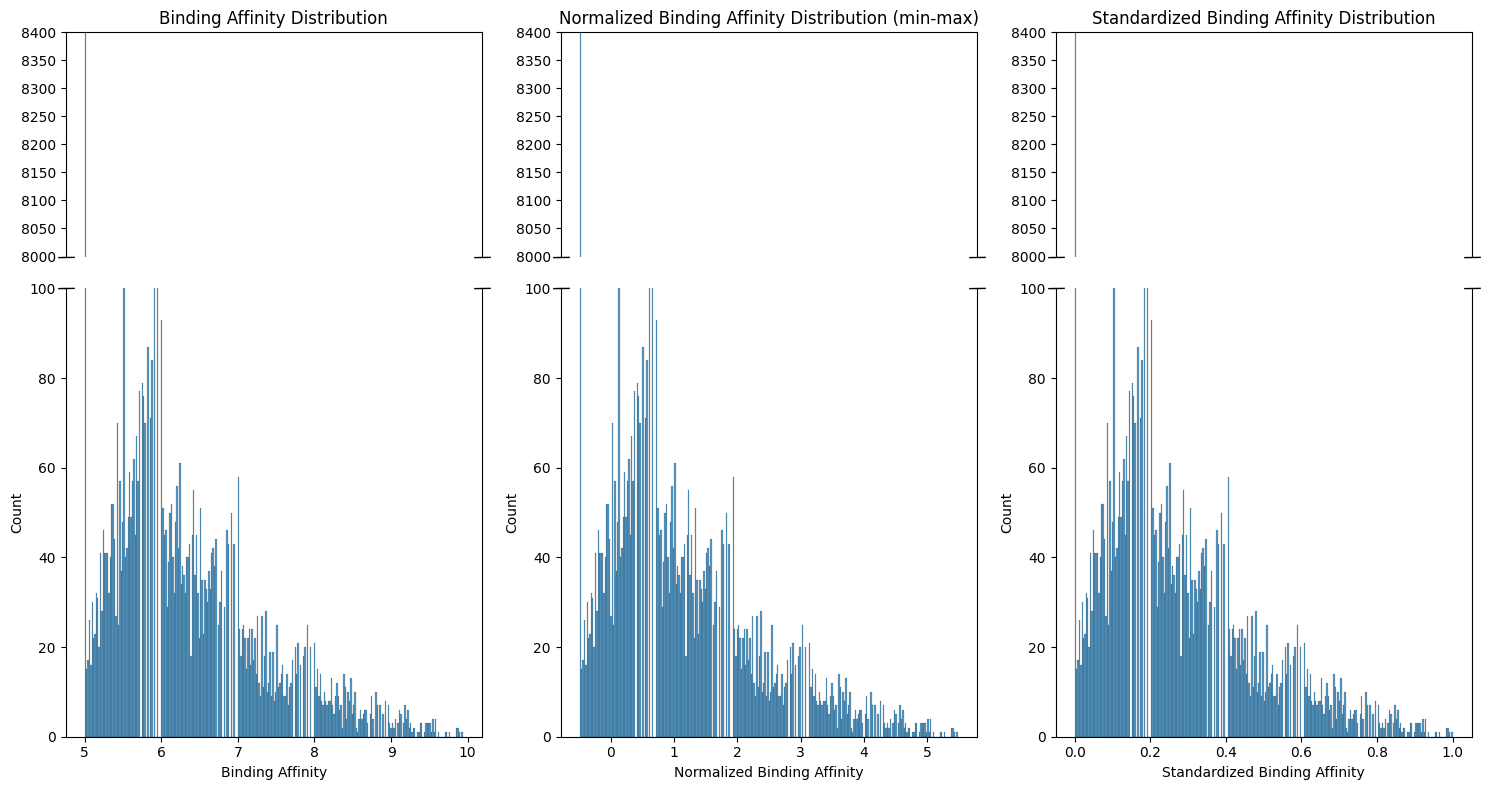

Found local copy...
Loading...
Done!



Drug & Target properties: KIBA


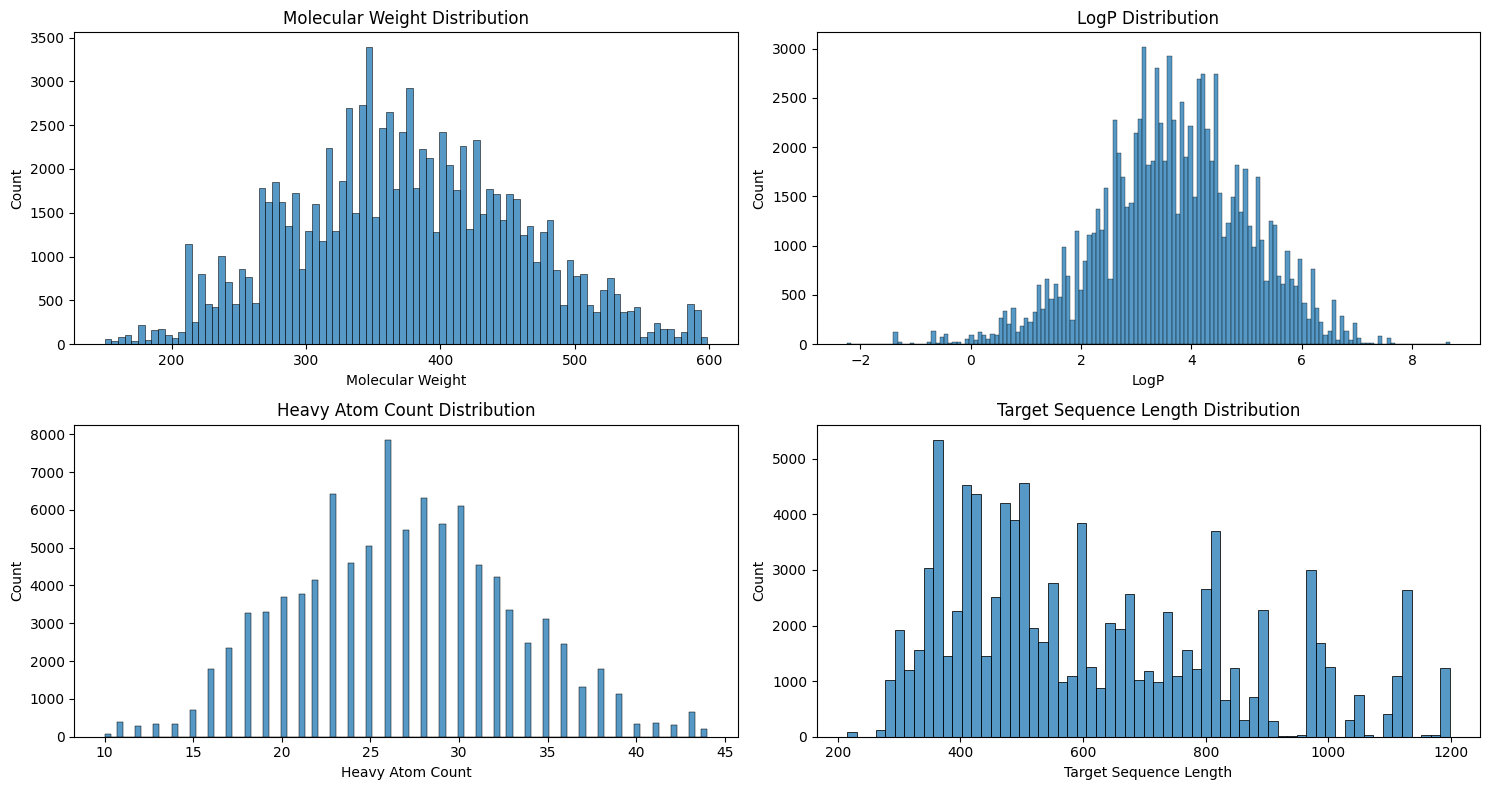


Binding affinity: KIBA


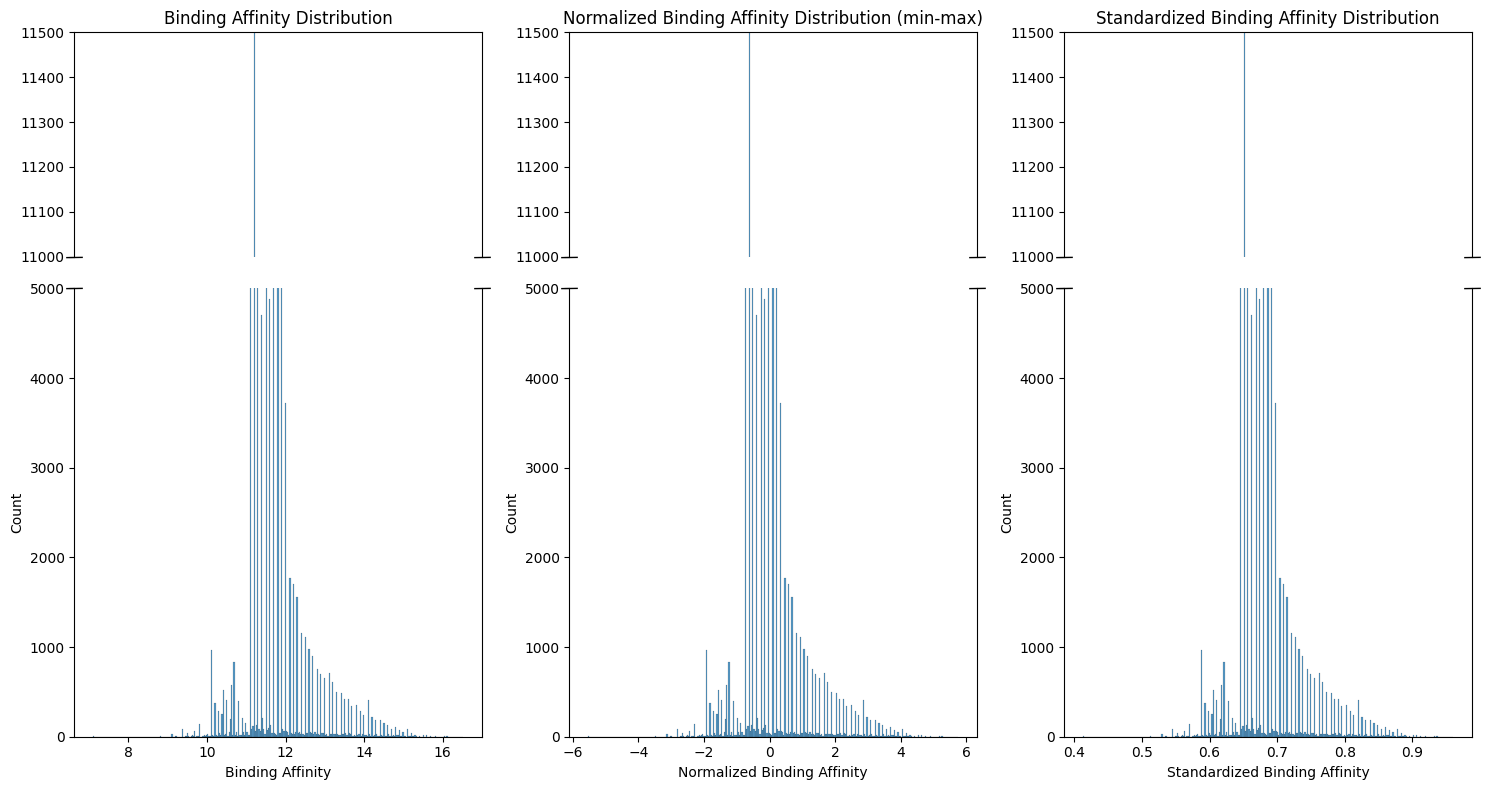

,Drug_ID,Drug,Target_ID,Target,Y,split_rand,split_cold
0,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,0.479284,train,test
1,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL1p,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0.000000,train,test
2,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL2,MVLGTVLLPPNSYGRDQDTSLCCLCTEASESALPDLTDHFASCVED...,0.000000,train,test
3,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1,MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...,0.000000,train,test
4,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR2A,MGAAAKLAFAVFLISCSSGAILGRSETQECLFFNANWEKDRTNQTG...,0.000000,train,test
...,...,...,...,...,...,...,...
25767,10184653,CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...,TNNI3K,MGNYKSRPTQTCTDEWKKKVSESYVITIERLEDDLQIKEKELTELR...,0.000000,test,test
25768,16725726,CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OCC3CCCNC...,FYN,MGCVQCKDKEATKLTEERDGSLNQSSGYRYGTDPTPQHYPSFGVTS...,0.000000,test,train
25769,11656518,Cn1c(Nc2ccc(C(F)(F)F)cc2)nc2cc(Oc3ccnc(-c4ncc(...,CAMKK1,MEGGPAVCCQDPRAELVERVAAIDVTHLEEADGGPEPTRNGVDPPP...,0.000000,test,test
25770,153999,CN(C)CC1CCn2cc(c3ccccc32)C2=C(C(=O)NC2=O)c2cn(...,IRAK3,MAGNCGARGALSAHTLLFDLPPALLGELCAVLDSCDGALGWRGLAE...,0.000000,test,train


In [2]:
df_davis = generate_df('DAVIS')
df_kiba = generate_df('KIBA')
df_davis

In [3]:
for df, name in zip([df_davis, df_kiba], ['DAVIS', 'KIBA']):
    print(f"\n{name} dataset:")
    print("Number of drugs:", df['Drug'].nunique())
    print("Number of targets:", df['Target'].nunique())
    print("Number of interactions:", len(df))


DAVIS dataset:
Number of drugs: 64
Number of targets: 332
Number of interactions: 21248

KIBA dataset:
Number of drugs: 1696
Number of targets: 204
Number of interactions: 98172


# Creating the Datasets

We use the [`h5torch`](https://h5torch.readthedocs.io/en/latest/index.html) package for saving our datasets. This format conveniently allows for fast loading of the data and easy access to the data in PyTorch.

In [3]:
import h5torch

def generate_h5torch(df: pd.DataFrame, name: Literal['DAVIS', 'KIBA']) -> None:
    """
    Generates and saves drugs x targets .h5t file for the given DTI dataframe.
    See: https://h5torch.readthedocs.io/en/latest/index.html
    Consists of:
        - Drugs x targets interaction matrix (y values) in COO format
        - Random & Cold split metadata for each y (train, valid, test)
        - Drug and target properties (ID, string representation)
    """
    # Get unique IDs and map them to integer indices
    unique_drugs = df["Drug_ID"].unique()
    unique_targets = df["Target_ID"].unique()

    drug_id2int = {drug: i for i, drug in enumerate(unique_drugs)}
    target_id2int = {target: i for i, target in enumerate(unique_targets)}

    df["Drug_index"] = df["Drug_ID"].map(drug_id2int)
    df["Target_index"] = df["Target_ID"].map(target_id2int)

    # Generate necessary COO matrix data
    coo_matrix_indices = df[["Drug_index", "Target_index"]].values.T
    coo_matrix_values = df["Y"].values.astype(np.float32)
    coo_matrix_shape = (df["Drug_index"].max(), df["Target_index"].max())

    # Gather IDs and string representations in order of the integer indices
    drug_int2id = {v : k for k, v in drug_id2int.items()}
    drug_int2smiles = {k : v for k, v in zip(df["Drug_index"], df["Drug"])}
    drug_id = np.array([drug_int2id[i] for i in range(df["Drug_index"].max())])
    drug_smiles = np.array([drug_int2smiles[i] for i in range(df["Drug_index"].max())])

    target_int2id = {v : k for k, v in target_id2int.items()}
    target_int2seq = {k : v for k, v in zip(df["Target_index"], df["Target"])}
    target_id = np.array([target_int2id[i] for i in range(df["Target_index"].max())])
    target_seq = np.array([target_int2seq[i] for i in range(df["Target_index"].max())])

    # Construct the h5torch file
    f = h5torch.File("./data/" + name + ".h5t", 'w')
    f.register((coo_matrix_indices, coo_matrix_values, coo_matrix_shape), axis="central", mode="coo", dtype_save="float32", dtype_load="float32")
    f.register(drug_id, axis=0, name="Drug_ID", dtype_save="bytes", dtype_load="str")
    f.register(drug_smiles, axis=0, name="Drug_SMILES", dtype_save="bytes", dtype_load="str")
    f.register(target_id, axis=1, name="Target_ID", dtype_save="bytes", dtype_load="str")
    f.register(target_seq, axis=1, name="Target_seq", dtype_save="bytes", dtype_load="str")
    f.register(df["split_rand"], axis="unstructured", name="split_rand", dtype_save="bytes", dtype_load="str")
    f.register(df["split_cold"], axis="unstructured", name="split_cold", dtype_save="bytes", dtype_load="str")
    f.close()

generate_h5torch(df_davis, "DAVIS")
generate_h5torch(df_kiba, "KIBA")

In [4]:
# Example use
davis_train_dataset = h5torch.Dataset(
    "./data/DAVIS.h5t",
    sampling="coo",
    subset=("unstructured/split_rand", "train"),
    in_memory=True,
)

len(davis_train_dataset), davis_train_dataset[100]

(7934,
 {'central': 0.0,
  '0/Drug_ID': '11314340',
  '0/Drug_SMILES': 'Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12',
  '1/Target_ID': 'LZK',
  '1/Target_seq': 'MANFQEHLSCSSSPHLPFSESKTFNGLQDELTAMGNHPSPKLLEDQQEKGMVRTELIESVHSPVTTTVLTSVSEDSRDQFENSVLQLREHDESETAVSQGNSNTVDGESTSGTEDIKIQFSRSGSGSGGFLEGLFGCLRPVWNIIGKAYSTDYKLQQQDTWEVPFEEISELQWLGSGAQGAVFLGKFRAEEVAIKKVREQNETDIKHLRKLKHPNIIAFKGVCTQAPCYCIIMEYCAHGQLYEVLRAGRKITPRLLVDWSTGIASGMNYLHLHKIIHRDLKSPNVLVTHTDAVKISDFGTSKELSDKSTKMSFAGTVAWMAPEVIRNEPVSEKVDIWSFGVVLWELLTGEIPYKDVDSSAIIWGVGSNSLHLPVPSTCPDGFKILMKQTWQSKPRNRPSFRQTLMHLDIASADVLATPQETYFKSQAEWREEVKKHFEKIKSEGTCIHRLDEELIRRRREELRHALDIREHYERKLERANNLYMELSAIMLQLEMREKELIKREQAVEKKYPGTYKRHPVRPIIHPNAMEKLMKRKGVPHKSGMQTKRPDLLRSEGIPTTEVAPTASPLSGSPKMSTSSSKSRYRSKPRHRRGNSRGSHSDFAAILKNQPAQENSPHPTYLHQAQSQYPSLHHHNSLQQQYQQPPPAMSQSHHPRLNMHGQDIATCANNLRYFGPAAALRSPLSNHAQRQLPGSSPDLISTAMAADCWRSSEPDKGQAGPWGCCQADAYDPCLQCRPEQYGSLDIPSAEPVGRSPDLSKSPAHNPLLENAQSSEKTEENEFSGCRSESSLGTSHLGTPPALPRKTRPLQKSGDDSSEEEEGEVDSEVEFPRRQRPHR

In [ ]:
import torch

# note that the items must be decoded from bytes with e.g. `item.decode('utf-8')`
davis_train_dataloader = torch.utils.data.DataLoader(davis_train_dataset, batch_size=4, shuffle=True)
batch = next(iter(davis_train_dataloader))
batch

{'central': tensor([0.0000, 0.0000, 0.0949, 0.0000]),
 '0/Drug_ID': ['10113978', '9926054', '16725726', '10427712'],
 '0/Drug_SMILES': ['Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S(N)(=O)=O',
  'Cc1ccc2nc(NCCN)c3ncc(C)n3c2c1.Cl',
  'CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OCC3CCCNC3)c21',
  'Nc1nc(N)c2nc(-c3cccc(O)c3)c(-c3cccc(O)c3)nc2n1'],
 '1/Target_ID': ['MKK7', 'CHEK2', 'NLK', 'RIOK3'],
 '1/Target_seq': ['MAASSLEQKLSRLEAKLKQENREARRRIDLNLDISPQRPRPTLQLPLANDGGSRSPSSESSPQHPTPPARPRHMLGLPSTLFTPRSMESIEIDQKLQEIMKQTGYLTIGGQRYQAEINDLENLGEMGSGTCGQVWKMRFRKTGHVIAVKQMRRSGNKEENKRILMDLDVVLKSHDCPYIVQCFGTFITNTDVFIAMELMGTCAEKLKKRMQGPIPERILGKMTVAIVKALYYLKEKHGVIHRDVKPSNILLDERGQIKLCDFGISGRLVDSKAKTRSAGCAAYMAPERIDPPDPTKPDYDIRADVWSLGISLVELATGQFPYKNCKTDFEVLTKVLQEEPPLLPGHMGFSGDFQSFVKDCLTKDHRKRPKYNKLLEHSFIKRYETLEVDVASWFKDVMAKTESPRTSGVLSQPHLPFFR',
  'MSRESDVEAQQSHGSSACSQPHGSVTQSQGSSSQSQGISSSSTSTMPNSSQSSHSSSGTLSSLETVSTQELYSIPEDQEPEDQEPEEPTPAPWARLWALQDGFANLECVNDNYWFGRDKSCEYCFDEPLLKRTDKYRTYSKKHFRIFREVGPKNSYIAYIED

---
---

> Issue with rounding?

In [7]:
print(batch["central"][0])
batch["central"][1].dtype

tensor(0.1332)


torch.float32

In [8]:
map = (df_davis["Drug_ID"] == 25127112) & (df_davis["Target_ID"] == "MELK")
print(type(df_davis[map].iloc[0]["Y"]))
print(df_davis[map].iloc[0]["Y"])
df_davis[map]

<class 'numpy.float64'>
0.1332298138378997


,Drug_ID,Drug,Target_ID,Target,Y,split_rand,split_cold,Drug_index,Target_index
13169,25127112,N#CCC(C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1.O=P(O...,MELK,MKDYDELLKYYELHETIGTGGFAKVKLACHILTGEMVAIKIMDKNT...,0.13323,train,train,26,250


In [9]:
df_davis[map].iloc[0]["Y"].astype(np.float32)

0.1332298

---
---

# Adding Embeddings

Because we will (for now) not be fine-tuning the foundation models used, we pre-compute the embeddings associated with the drug (SMILES strings) and targets (amino acid sequence) data. These embeddings are then saved in the same `h5t` file as the datasets.

## Generating Embeddings
- Drug embeddings with [`ibm/biomed.sm.mv-te-84m`](https://huggingface.co/ibm/biomed.sm.mv-te-84m)
- Target embeddings with [`Rostlab/ProstT5`](https://huggingface.co/Rostlab/ProstT5)

In [ ]:
from models import BiomedMultiViewMoleculeEncoder
from models import T5ProstTargetEncoder


class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, name: Literal["DAVIS", "KIBA"], mode: Literal["drug", "target"]):
        f = h5torch.File("./data/" + name + ".h5t", 'r')
        export = f["0/Drug_SMILES"][:] if mode == "drug" else f["1/Target_seq"][:]
        self.data = [s.decode("utf-8") for s in export]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


def get_loaders(name: Literal["DAVIS", "KIBA"], batch_size: int = 16):
    drug_dataset = EmbeddingDataset(name, "drug")
    target_dataset = EmbeddingDataset(name, "target")
    
    drug_loader = torch.utils.data.DataLoader(drug_dataset, batch_size=batch_size, shuffle=False)
    target_loader = torch.utils.data.DataLoader(target_dataset, batch_size=batch_size, shuffle=False)

    print(f"Number of drugs & batches: {len(drug_dataset)}, {len(drug_loader)}")
    print(f"Number of targets & batches: {len(target_dataset)}, {len(target_loader)}")
    
    return drug_loader, target_loader


def get_embeddings(name: Literal["DAVIS", "KIBA"]):
    drug_loader, target_loader = get_loaders("DAVIS")

    # Drug embeddings
    print("\nDrug embeddings")
    drug_encoder = BiomedMultiViewMoleculeEncoder()
    graph_embeddings = []
    image_embeddings = []
    text_embeddings = []

    for i, batch in enumerate(drug_loader):
        print(f"Batch {i+1}/{len(drug_loader)}")
        graph, image, text = drug_encoder(batch)
        graph_embeddings.append(graph)
        image_embeddings.append(image)
        text_embeddings.append(text)

    graph_embeddings = torch.cat(graph_embeddings, dim=0) # (num_drugs, 512)
    image_embeddings = torch.cat(image_embeddings, dim=0) # (num_drugs, 512)
    text_embeddings = torch.cat(text_embeddings, dim=0)   # (num_drugs, 768)

    # Target embeddings
    print("\nTarget embeddings")
    target_encoder = T5ProstTargetEncoder(AA_SEQ_CAP=1024)
    target_embeddings = []

    for i, batch in enumerate(target_loader):
        print(f"Batch {i+1}/{len(target_loader)}")
        target = target_encoder(batch)
        target_embeddings.append(target)

    target_embeddings = torch.cat(target_embeddings, dim=0) # (num_targets, 1024)

    return graph_embeddings, image_embeddings, text_embeddings, target_embeddings

Number of drugs & batches: 36, 3
Number of targets & batches: 308, 20


In [ ]:
def add_embeddings(
        name: Literal('DAVIS', 'KIBA'),
        graph_emb: np.ndarray,
        image_emb: np.ndarray,
        text_emb: np.ndarray,
        T5_emb: np.ndarray
    ):
    """
    Adds drug and target embeddings to the h5torch file.
    - Takes view embeddings for drugs and targets, each with shape n x D (i.e. n_drugs, 512)
    - Make sure the order of embeddings matches the order of IDs in the h5torch file (i.e. f["0/Drug_SMILES"][:])
    """
    f = h5torch.File("./data/" + name + ".h5t", 'a')
    # f.visititems(print)
    n_drugs = f["0/Drug_ID"].shape[0]
    n_targets = f["1/Target_ID"].shape[0]

    for emb, name in zip([graph_emb, image_emb, text_emb], ["graph_emb", "image_emb", "text_emb"]):
        assert emb.shape[0] == n_drugs, f"Drug {name} embedding size mismatch with number of drugs"
    assert T5_emb.shape[0] == n_targets, "Target T5 embedding size mismatch with number of targets"

    f.register(graph_emb, axis=0, name="graph_emb", dtype_save="float32", dtype_load="float32")
    f.register(image_emb, axis=0, name="image_emb", dtype_save="float32", dtype_load="float32")
    f.register(text_emb, axis=0, name="text_emb", dtype_save="float32", dtype_load="float32")
    f.register(T5_emb, axis=1, name="T5_emb", dtype_save="float32", dtype_load="float32")
    f.close()

In [ ]:
for dataset in ["DAVIS", "KIBA"]:
    graph_emb, image_emb, text_emb, T5_emb = get_embeddings(dataset)
    add_embeddings(dataset, graph_emb, image_emb, text_emb, T5_emb)

---
---

We encode molecules through one-hot-encoding of [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html) features


Example molecule:  CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4ccccn4)c(Cl)c3)c2cc1NC(=O)C=CCN(C)C
Number of atoms:  40
Number of bonds:  43


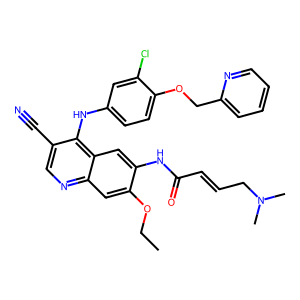

Converting SMILES to torch_geometric Data instance for:  CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4ccccn4)c(Cl)c3)c2cc1NC(=O)C=CCN(C)C
Number of nodes:  40
Node features:  torch.Size([40, 9]) 
- example: tensor([6, 0, 4, 5, 3, 0, 4, 0, 0]) 
- out of classes:  [119, 9, 11, 12, 9, 5, 8, 2, 2]

Number of edges:  86
Edges have to be represented undirected as a COO tensor
Edge features:  torch.Size([86, 3]) 
- example: tensor([1, 0, 0]) 
- out of classes:  [22, 6, 2]


In [34]:
from encoding import smiles2pydata

print("\nExample molecule: ", batch_drugs[0])
example_drug = smiles2pydata(batch_drugs[0], with_hydrogen=False, give_description=True)

---
---

# Encoding

## Encoding drug-molecules

Molecules in SMILES fromat are embedded through 3 views: MolGraph, Image, SMILES

See
 - https://github.com/BiomedSciAI/biomed-multi-view
 - https://huggingface.co/ibm/biomed.sm.mv-te-84m

In [35]:
from models import DrugBranch

model_drug = DrugBranch(
    embeddings_sizes = [512, 512, 768],
    hidden_dim = 512,
    latent_dim = 1024
)
z_drug, loss_recon, loss_kl = model_drug.forward(batch_drugs, compute_loss=True)
print("Output: ", z_drug.shape)
print("Reconstruction loss : ", loss_recon)
print("KL divergence loss  : ", loss_kl)

2024-11-12 13:49:52,240 - root - INFO - pop-os:140359170866944:0:0 - BioMed Multi-view embedding model
2024-11-12 13:49:52,241 - root - INFO - pop-os:140359170866944:0:0 - dim_list [512, 512, 768] of Graph2dModel, ImageModel, TextModel
2024-11-12 13:49:52,252 - root - INFO - pop-os:140359170866944:0:0 - Loading checkpoint from provided path ../data_root/bmfm_model_dir/biomed-smmv-base.pth
2024-11-12 13:49:52,446 - root - INFO - pop-os:140359170866944:0:0 - Loading pretrain checkpoint for SmallMoleculeMultiView Model - _IncompatibleKeys(missing_keys=['aggregator.projections.0.weight', 'aggregator.projections.0.bias', 'aggregator.projections.1.weight', 'aggregator.projections.1.bias', 'aggregator.projections.2.weight', 'aggregator.projections.2.bias', 'aggregator.w_before_mean.0.weight', 'aggregator.w_before_mean.0.bias', 'aggregator.w_before_mean.2.weight', 'aggregator.down_project.weight', 'aggregator.down_project.bias', 'aggregator.shared_task_head.0.weight', 'aggregator.shared_task_h


Number of parameters per component
SMVV encoder       : 81,329,728
Branch up
- Encodings to Z   : 3,551,744
- Aggregator to Z* : 3,023,872
- Aggrigate to Z*  : 1,577,984
Branch down
- Z* to Aggrigate' : 1,052,160
- Expander to Z'   : 2,761,984
- Z' to Encodings' : 2,632,448

Output:  torch.Size([16, 1024])
Reconstruction loss :  tensor(1.3475, grad_fn=<AddBackward0>)
KL divergence loss  :  tensor(306.8239, grad_fn=<AddBackward0>)


## Encoding target-proteins

Proteins in amino-acid sequence format are embedded through 1 view: amino-acid sequence

See
 - https://github.com/mheinzinger/ProstT5
 - https://huggingface.co/Rostlab/ProstT5

In [38]:
from models import TargetBranch

model_target = TargetBranch(
    input_dim = 1024,
    hidden_dim = 512,
    latent_dim = 1024
)
z_target, loss_recon, loss_kl = model_target.forward(batch_targets, compute_loss=True)
print("Output: ", z_drug.shape)
print("Reconstruction loss : ", loss_recon)
print("KL divergence loss  : ", loss_kl)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



Number of parameters per component
Protein encoder: 1,208,164,352
Branch up
- Encodings to Z: 2,103,808
Branch down
- Z to Encodings: 1,051,136

Output:  torch.Size([16, 1024])
Reconstruction loss :  tensor(0.1399, grad_fn=<MseLossBackward0>)
KL divergence loss  :  tensor(111.0991, grad_fn=<MeanBackward0>)
